In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load Data

In [2]:
filename = 'Datasets/All_subjects_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/All_subjects_RDmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [3]:
filename = 'Datasets/All_subjects_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/All_subjects_RAmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [4]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)
(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)


In [5]:
filename = 'Datasets/All_subjects_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/All_subjects_spectrogram.hdf5
(527, 120, 128, 128, 3)
(527, 120, 19)
(132, 120, 128, 128, 3)
(132, 120, 19)


In [6]:
filename = 'Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5
(527, 1482)
(527,)
(132, 1482)
(132,)


In [7]:
filename = 'Datasets/All_subjects_spect_single.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train4 = np.array(data["train_img"])
x_test4 = np.array(data["test_img"])
data.close()
print(x_train4.shape)
print(x_test4.shape)

Selected File: Datasets/All_subjects_spect_single.hdf5
(527, 128, 128, 3)
(132, 128, 128, 3)


##### STA LTA

In [8]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [9]:
duration = 24.2
nsta_sec = 0.7
ratio = margin_tr.shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,margin_ts.shape[1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

In [10]:
# downsample the mask to vid
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train.shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train.shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(527, 605)
(132, 605)
(527, 120)
(132, 120)


In [11]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [12]:
numgest = [gesture_counter(m) for m in mask_spect_ts]
sum(numgest)

813

In [13]:
num_class = y_test3.shape[2]
num_class

19

In [14]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [15]:
x1train, y1train = masker(x_train11, y_train3, mask_spect_tr)
x1test, y1test = masker(x_test11, y_test3, mask_spect_ts)
x2train, y2train = masker(x_train12, y_train3, mask_spect_tr)
x2test, y2test = masker(x_test12, y_test3, mask_spect_ts)
x3train, y3train = masker(x_train3, y_train3, mask_spect_tr)
x3test, y3test = masker(x_test3, y_test3, mask_spect_ts)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

/home/m/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)


In [16]:
y_int_train = np.array([np.argmax(y,-1) for y in y3train])
y_int_test = np.array([np.argmax(y,-1) for y in y3test])
print(y_int_train.shape)

(3042,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### Multi-task labels

In [17]:
y_asldaily_tr = [] # 0: daily, 1: asl
y_twohanded_tr = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_tr = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_tr = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_tr = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

y_asldaily_ts = [] # 0: daily, 1: asl
y_twohanded_ts = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_ts = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_ts = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_ts = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

## asl daily
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_tr.append(to_categorical(yx,2))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_ts.append(to_categorical(yx,2))
    
## two hand
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_tr.append(to_categorical(yx,3))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_ts.append(to_categorical(yx,3))

## hand loc
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] == 4:
            yx[j] = 1
        elif y_int_train[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_train[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_tr.append(to_categorical(yx,5))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] == 4:
            yx[j] = 1
        elif y_int_test[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_test[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_ts.append(to_categorical(yx,5))

## movement type
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_train[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_train[i][j] == 13:
            yx[j] = 3
        elif y_int_train[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_tr.append(to_categorical(yx,6))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_test[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_test[i][j] == 13:
            yx[j] = 3
        elif y_int_test[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_ts.append(to_categorical(yx,6))
    
## # of strokes
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_train[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_tr.append(to_categorical(yx,4))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_test[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_ts.append(to_categorical(yx,4))

### CTC labels

In [18]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [1]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y6train]
ctc_ts3 = [num_to_ch(y) for y in y6test]

NameError: name 'y6train' is not defined

In [20]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [21]:
def data_generator_multi_nolabel_rd(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [22]:
predict_generator = data_generator_multi_nolabel_rd([x1test, x2test, x3test])
predict_generator_seq = data_generator_multi_nolabel_rd([x_test11, x_test12, x_test3])

In [23]:
fname = 'ctc aux multiinput multitask 92-03'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path
json_file = open(MODEL_FILE, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_load = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_load.load_weights(WEIGHT_FILE)

In [24]:
prediction_model = keras.models.Model(
    [model_load.get_layer(name="rd").input, model_load.get_layer(name="ra").input, model_load.get_layer(name="image").input], model_load.get_layer(name="dense2").output
)

In [25]:
probs = np.array([np.squeeze(prediction_model.predict(next(predict_generator))) for i in range(len(x3test))],dtype=object)
pred = np.array([np.argmax(probs[i],-1) for i in range(len(x3test))], dtype = object)

In [26]:
pred_labels = []

for p in pred:
    label = []
    for num in p:
        if num == 20:# or chr(ord('@')+num) == 'A':
            continue
        label.append(num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels,dtype=object)  
print(pred_labels[3])

[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1, 1, 1]


In [27]:
prb_ls = []

for i in range(len(pred)):
    prb = []
    for j in range(len(pred[i])):
        if pred[i][j] == 20:# or chr(ord('@')+num) == 'A':
            continue
        prb.append(probs[i][j,:])
    prb_ls.append(prb)
prb_ls = np.array(prb_ls,dtype=object)  

In [28]:
from collections import Counter
mode_orig = [max(Counter(np.argmax(y,-1)+1)) for y in y3test]
mode_pred = [max(Counter(y)) if len(y) != 0 else 1 for y in pred_labels]

In [29]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(y3test))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

92.02702702702703

In [30]:
Counter(mode_orig)

Counter({2: 89,
         3: 128,
         14: 33,
         15: 33,
         16: 41,
         4: 121,
         11: 28,
         12: 25,
         13: 27,
         8: 21,
         9: 26,
         10: 29,
         5: 20,
         7: 23,
         6: 17,
         17: 27,
         18: 25,
         19: 27})

### long sequences

In [31]:
# probs_seq = np.array([np.squeeze(prediction_model.predict(next(predict_generator_seq))) for i in range(len(x3test))],dtype=object)
# pred_seq = np.array([np.argmax(probs_seq[i],-1) for i in range(len(x3test))], dtype = object)

In [32]:
# pred_labels_seq = []

# cnt = 1
# for p in pred_seq:
#     label = []
#     for num in p:
#         if num == 20:# or chr(ord('@')+num) == 'A':
#             continue
#         label.append(num)
#     pred_labels_seq.append(label)
# pred_labels_seq = np.array(pred_labels_seq,dtype=object)  
# print(pred_labels_seq[2])

In [33]:
# from collections import Counter
# mode_orig_seq = [max(Counter(np.argmax(y,-1)+1)) for y in y_test3]
# mode_pred_seq = [max(Counter(y)) if len(y) != 0 else 1 for y in pred_labels_seq]

In [34]:
# for i in range(10):
#     print(str(i+1) + '. '+ str(np.argmax(y_test3[i],-1)) + ' | ' + str(pred_labels_seq[i]))

## Trigger Detect

In [35]:
from IPython.display import clear_output

In [36]:
asl_dict = {5:'Tired',6:'Book',7:'Sleep',8:'Evening',9:'Ready',10:'Hot',11:'Month',12:'Cook',13:'Again',
           14:'Summon',15:'Maybe',16:'Night',17:'Something',18:'Teacher',19:'Teach'}

In [37]:
# params
sign = range(5,20,1)
low_cf = 0.8 # confidence
high_cf = 0.8 # confidence
samp_th = np.linspace(0.1,0.99,90)

In [38]:
def high_trig(sign,high_cf,samp_th):
    high_th = [round(len(y)*samp_th*high_cf) for y in y3test]
    scores = np.array([np.array(p)[:,sign] for p in prb_ls],dtype=object)
    acc_scores = np.array([sum(s) for s in scores],dtype=object)
    num_sign = sum(np.array(mode_orig)==sign)
    falses = 0
    rejects = 0
    for i in range(len(mode_orig)):
        if acc_scores[i] > high_th[i] and mode_orig[i] != sign:
            falses += 1
        if acc_scores[i] < high_th[i] and mode_orig[i] == sign:
            rejects += 1
    far = falses/num_sign
    frr = rejects/num_sign
    return far, frr, rejects, falses

In [39]:
far_ls = np.zeros([len(sign),len(samp_th)])
frr_ls = np.zeros([len(sign),len(samp_th)])
rejects = np.zeros([len(sign),len(samp_th)])
falses = np.zeros([len(sign),len(samp_th)])
for i in range(len(sign)):
    for j in range(len(samp_th)):
        far_ls[i,j], frr_ls[i,j], rejects[i,j], falses[i,j] = high_trig(sign[i],high_cf,samp_th[j])
        clear_output(wait=True)
        print('Processing: '+str(i*len(samp_th)+j)+'/'+str(len(sign)*len(samp_th)))

Processing: 1349/1350


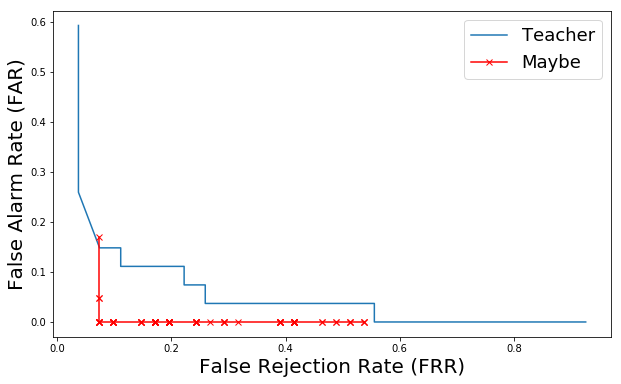

In [40]:
# p1, = plt.plot(frr_ls[14],far_ls[14])
# p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
p1, = plt.plot(frr_ls[8],far_ls[8])
p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
plt.legend([p1,p2], ('Teacher', 'Maybe'), fontsize=20,
           prop={'weight':'normal','size':18},loc='upper right')
# plt.ylim([-0.2,0.2])
# plt.xlim([0,0.007])
fig = plt.gcf()
fig.set_size_inches(10,6)

In [41]:
det_rates = 1 - sum(far_ls,frr_ls)
print('Max det rate: ' + str(np.max(det_rates)) + ', class: '+asl_dict[sign[np.argmax(np.amax(det_rates,-1),-1)]])

Max det rate: 0.88, class: Teacher


In [42]:
maxes = np.amax(det_rates,-1)
maxes

array([0.75      , 0.58276473, 0.47913681, 0.53296703, 0.76007326,
       0.70702286, 0.52106227, 0.55391941, 0.35836386, 0.55028305,
       0.58058608, 0.52367551, 0.72873423, 0.88      , 0.69169719])

Text(0, 0.5, 'Detection Rate')

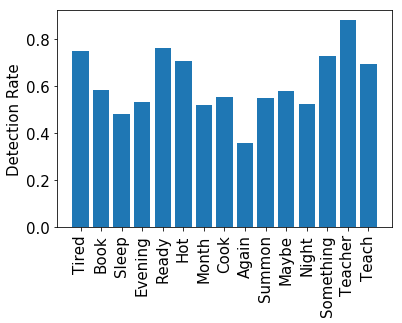

In [43]:
plt.bar(asl_dict.values(),maxes)
plt.xticks(rotation = 90)
plt.ylabel('Detection Rate',fontsize=15, weight='normal')
# plt.savefig('results/high detect.png', bbox_inches='tight')

### Low th method

In [44]:
def low_trig(sign,high_cf,low_cf,samp_th):
    high_th = [round(len(y)*samp_th*high_cf) for y in y3test]
    scores = np.array([np.array(p)[:,sign] for p in prb_ls],dtype=object)
    acc_scores = np.array([sum(s) for s in scores],dtype=object)
    num_sign = sum(np.array(mode_orig)==sign)
    falses = 0
    rejects = 0
    for i in range(len(mode_orig)):
        if acc_scores[i] > high_th[i] and mode_orig[i] != sign:
            falses += 1
        if acc_scores[i] < high_th[i] and mode_orig[i] == sign:
            cmp = np.nonzero(scores[i] > low_cf)[0]
            
            if cmp.size !=0:
                nnzlen = cmp[-1] - cmp[0]
#                 print(str(i)+ '. '+str(nnzlen))
                if nnzlen > len(y3test[i])/2: # /2
                    continue
            rejects += 1
    far = falses/num_sign
    frr = rejects/num_sign
    return far, frr, rejects, falses

In [45]:
far_ls_low = np.zeros([len(sign),len(samp_th)])
frr_ls_low = np.zeros([len(sign),len(samp_th)])
rejects_low = np.zeros([len(sign),len(samp_th)])
falses_low = np.zeros([len(sign),len(samp_th)])
for i in range(len(sign)):
    for j in range(len(samp_th)):
        far_ls_low[i,j], frr_ls_low[i,j], rejects_low[i,j], falses_low[i,j] = low_trig(sign[i],high_cf,low_cf,samp_th[j])
        clear_output(wait=True)
        print('Processing: '+str(i*len(samp_th)+j)+'/'+str(len(sign)*len(samp_th)))

Processing: 1349/1350


In [46]:
det_rates_low = 1 - sum(far_ls_low,frr_ls_low)
print('Max det rate: ' + str(np.max(det_rates_low)) + ', class: '+asl_dict[sign[np.argmax(np.amax(det_rates_low,-1),-1)]])

Max det rate: 0.96, class: Teacher


In [47]:
maxes_low = np.amax(det_rates_low,-1)
maxes_low

array([0.8       , 0.70588235, 0.60869565, 0.61904762, 0.92307692,
       0.79310345, 0.59249084, 0.64      , 0.55555556, 0.72727273,
       0.66666667, 0.65853659, 0.77777778, 0.96      , 0.77777778])

In [48]:
# plt.bar(asl_dict.values(),maxes)
# plt.xticks(rotation = 90)
# plt.ylabel('Detection Rate',fontsize=15, weight='normal')
# plt.savefig('results/low detect.png', bbox_inches='tight')

In [49]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    hatches = ['/', '']
    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)],
                        hatch = hatches[i])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(),loc='best')

In [50]:
data

<Closed HDF5 file>

In [51]:
data = {}
lsx = [maxes, maxes_low]
ls_th = ['Single Threshold', 'Double Threshold']
for key in ls_th:
    for val in lsx:
        data[key] = val
        lsx.remove(val)
        break

In [52]:
csfont = {'fontname': 'Comic Sans MS'}

Text(0, 0.5, 'Detection Rate')

/home/m/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


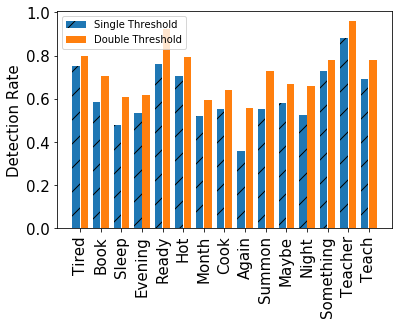

In [53]:
fig, ax = plt.subplots()
bar_plot(ax, data, total_width=.8, single_width=.9)
plt.rcParams['font.family'] = 'Comic Sans MS'
plt.xticks(range(15), asl_dict.values())
plt.xticks(rotation = 90)
plt.ylabel('Detection Rate',fontsize=15, weight='normal', **csfont)
# plt.savefig('results/comp th.png', bbox_inches='tight', dpi=500)

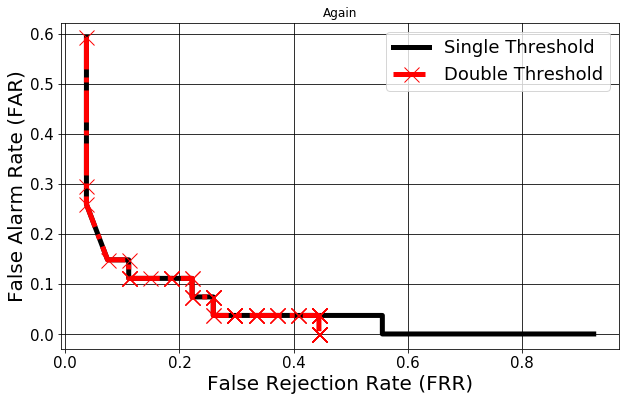

In [54]:
# p1, = plt.plot(frr_ls[14],far_ls[14])
# p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
idx = 10 #8
for idx in range(8,9): # plotted with low thesold diving factor of 20, not 2
    plt.figure()
    p1, = plt.plot(frr_ls[idx],far_ls[idx],'k',linewidth=5)
    p2, = plt.plot(frr_ls_low[idx],far_ls_low[idx],'-.xr',linewidth=5,markersize=15)
    matplotlib.rc('xtick',labelsize=15)
    matplotlib.rc('ytick',labelsize=15)
    plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
    plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
    plt.legend([p1,p2], ('Single Threshold', 'Double Threshold'), fontsize=20,
               prop={'weight':'normal','size':18},loc='best')
    plt.title(asl_dict[idx+5])
    plt.grid(color='k')
    # plt.ylim([-0.2,0.2])
    # plt.xlim([0,0.007])
    fig = plt.gcf()
    fig.set_size_inches(10,6)
#     plt.savefig('results/again double th.png', bbox_inches='tight', dpi = 500)

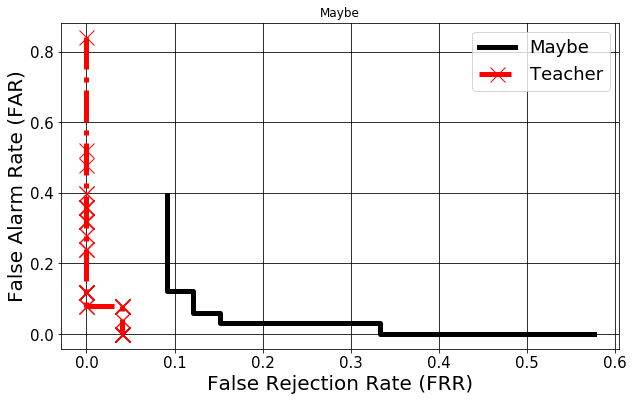

In [55]:
# p1, = plt.plot(frr_ls[14],far_ls[14])
# p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
idx = 10 # maybe = 10
idx2 = 13 # teacher = 13
plt.figure()
p1, = plt.plot(frr_ls[idx],far_ls[idx],'k',linewidth=5)
p2, = plt.plot(frr_ls_low[idx2],far_ls_low[idx2],'-.xr',linewidth=5,markersize=15)
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
plt.legend([p1,p2], ('Maybe', 'Teacher'), fontsize=20,
           prop={'weight':'normal','size':18},loc='best')
plt.title(asl_dict[idx+5])
plt.grid(color='k')
# plt.ylim([-0.2,0.2])
# plt.xlim([0,0.007])
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.savefig('results/maybe vs teacher.png', bbox_inches='tight', dpi = 500)

### Aux plots

In [85]:
len(ls_th)

2

In [100]:
g2

0.8372859025032938

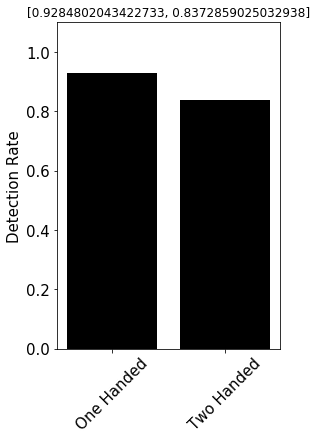

In [106]:
# Two handed
idx = np.array([10, 17]) - 5
g1 = np.mean(maxes_low[tuple([idx])])
g2 = np.mean(maxes_low[tuple([~idx])])

lsx = [g1, g2]
ls_th = ['One Handed', 'Two Handed']

fig, ax = plt.subplots()
plt.bar(ls_th, lsx,  color='black', align='center')
plt.xticks(range(len(ls_th)), ls_th)
plt.xticks(rotation = 45)
plt.ylabel('Detection Rate',fontsize=15, weight='normal')
plt.title(str(lsx))
# plt.ylim([0.8, 1])
fig.set_size_inches(4,6)
plt.ylim([0, 1.1])
plt.savefig('results/aux two hand.png', bbox_inches='tight', dpi = 500)

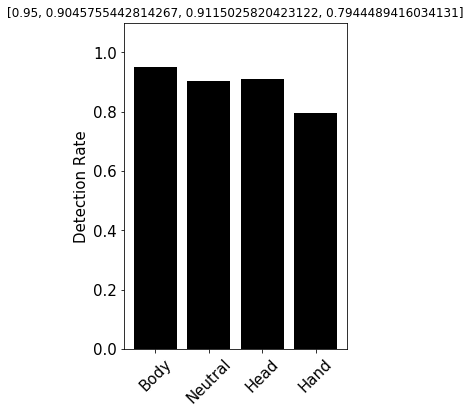

In [107]:
# major
body = np.array([5]) - 5
neural = np.array([6,9,15,17]) - 5
head = np.array([7,10,18,19]) - 5
hand = np.array([8,11,12,13,14,16]) - 5
g1 = np.mean(maxes_low[tuple([body])])
g2 = np.mean(maxes_low[tuple([neural])])
g3 = np.mean(maxes_low[tuple([head])])
g4 = np.mean(maxes_low[tuple([hand])])

lsx = [g1, g2, g3, g4]
ls_th = ['Body', 'Neutral', 'Head', 'Hand']

fig, ax = plt.subplots()
plt.bar(ls_th, lsx,  color='black', align='center')
plt.xticks(range(len(ls_th)), ls_th)
plt.xticks(rotation = 45)
plt.ylabel('Detection Rate',fontsize=15, weight='normal')
plt.title(str(lsx))
# plt.ylim([0.8, 1])
fig.set_size_inches(4,6)
plt.ylim([0, 1.1])
plt.savefig('results/aux major.png', bbox_inches='tight', dpi = 500)

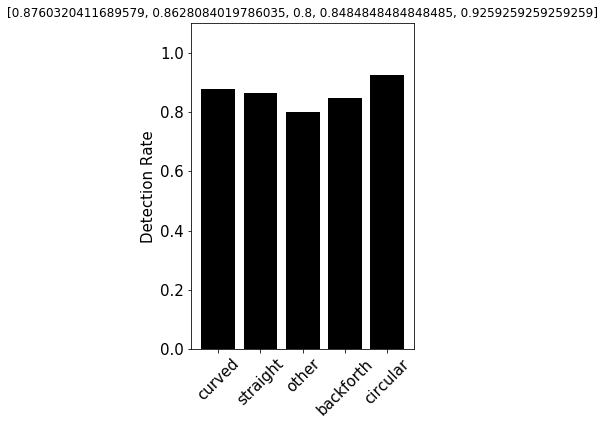

In [109]:
# Movement
curved = np.array([5,6,10,13]) - 5
straight = np.array([7,8,9,11,15,16,18,19]) - 5
other = np.array([12]) - 5
backforth = np.array([14]) - 5
circular = np.array([17]) - 5
g1 = np.mean(maxes_low[tuple([curved])])
g2 = np.mean(maxes_low[tuple([straight])])
g3 = np.mean(maxes_low[tuple([other])])
g4 = np.mean(maxes_low[tuple([backforth])])
g5 = np.mean(maxes_low[tuple([circular])])

lsx = [g1, g2, g3, g4, g5]
ls_th = ['curved', 'straight', 'other', 'backforth', 'circular']

fig, ax = plt.subplots()
plt.bar(ls_th, lsx,  color='black', align='center')
plt.xticks(range(len(ls_th)), ls_th)
plt.xticks(rotation = 45)
plt.ylabel('Detection Rate',fontsize=15, weight='normal')
plt.title(str(lsx))
# plt.ylim([0.8, 1])
fig.set_size_inches(4,6)
plt.ylim([0, 1.1])
plt.savefig('results/aux movement.png', bbox_inches='tight', dpi = 500)

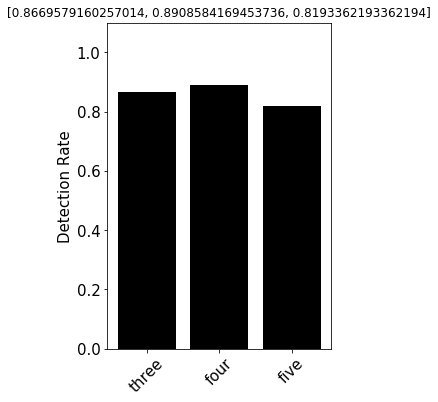

In [110]:
# stroke
three = np.array([5,6,10,11,14,16,19]) - 5
four = np.array([7,9,13,17,18]) - 5
five = np.array([8,12,15]) - 5
g1 = np.mean(maxes_low[tuple([three])])
g2 = np.mean(maxes_low[tuple([four])])
g3 = np.mean(maxes_low[tuple([five])])

lsx = [g1, g2, g3]
ls_th = ['three', 'four', 'five']

fig, ax = plt.subplots()
plt.bar(ls_th, lsx,  color='black', align='center')
plt.xticks(range(len(ls_th)), ls_th)
plt.xticks(rotation = 45)
plt.ylabel('Detection Rate',fontsize=15, weight='normal')
plt.title(str(lsx))
# plt.ylim([0.8, 1])
fig.set_size_inches(4,6)
plt.ylim([0, 1.1])
plt.savefig('results/aux stroke.png', bbox_inches='tight', dpi = 500)

In [ ]:
lsx = frr_ls_low
lsx2 = 
ls_th = asl_dict.values()
